# Chapter 10
## Simple learners

In [1]:
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split, cross_val_predict
from sklearn.naive_bayes import BernoulliNB
from sklearn.metrics import classification_report
from dtreeviz.trees import dtreeviz

## Decision trees

### Tennis

In [2]:
tennis = pd.read_feather("../datasets/tennis.feather")
tennis

,outlook,temperature,humidity,wind,play
0,Sunny,Hot,High,Weak,0
1,Sunny,Hot,High,Strong,0
2,Sunny,Mild,High,Weak,0
3,Sunny,Mild,Normal,Strong,1
4,Sunny,Cool,Normal,Weak,1
5,Overcast,Hot,High,Weak,1
6,Overcast,Hot,Normal,Weak,1
7,Overcast,Mild,High,Strong,1
8,Overcast,Cool,Normal,Strong,1
9,Rain,Mild,High,Weak,1


In [3]:
X = tennis[['outlook', 'temperature', 'humidity', 'wind']]
X = pd.get_dummies(X)
y = tennis.play

In [4]:
dt = DecisionTreeClassifier()
dt.fit(X.values, y)

DecisionTreeClassifier()

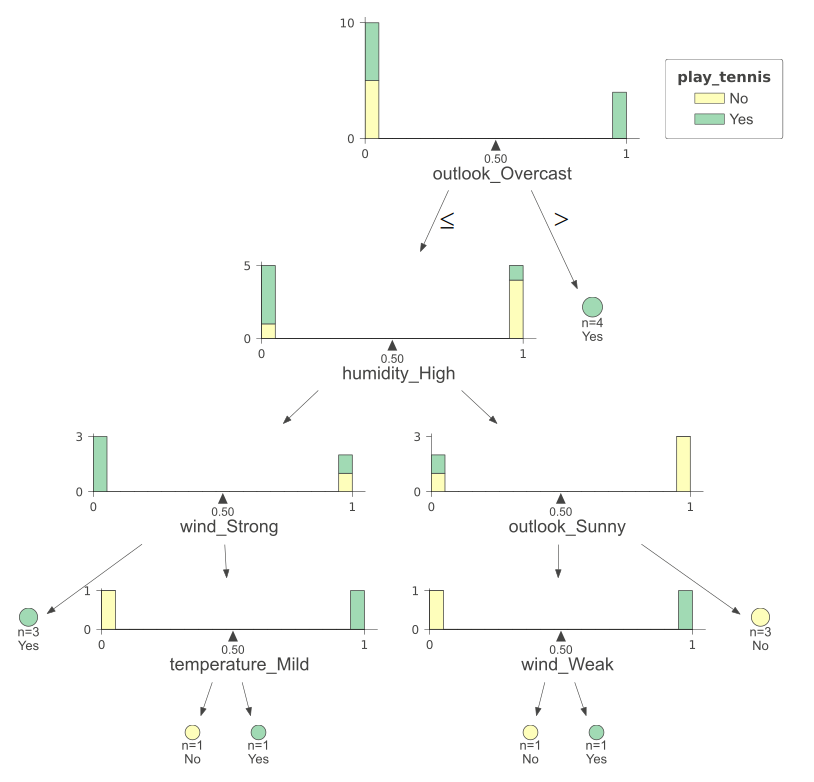

In [5]:
viz = dtreeviz(dt, X, y, target_name='play_tennis', feature_names=X.columns, class_names=['No', 'Yes'], scale=2.0)
viz

### Titanic

In [6]:
titanic = pd.read_feather("../datasets/titanic.feather")
titanic

,pclass,is_female,age,sibsp,parch,survived
0,1,1,29,0,0,1
1,1,0,0,1,2,1
2,1,1,2,1,2,0
3,1,0,30,1,2,0
4,1,1,25,1,2,0
...,...,...,...,...,...,...
1304,3,1,14,1,0,0
1305,3,1,9999,1,0,0
1306,3,0,26,0,0,0
1307,3,0,27,0,0,0


In [7]:
titanic_features = titanic.iloc[:,:-1]
titanic_labels = titanic.iloc[:,-1]

(titanic_features_train, titanic_features_test, titanic_labels_train, titanic_labels_test) = \
    train_test_split(titanic_features, titanic_labels, random_state=0, shuffle=True)

In [8]:
dt = DecisionTreeClassifier(min_samples_split=5)
dt.fit(titanic_features_train, titanic_labels_train)
accuracy = dt.score(titanic_features_test, titanic_labels_test)

print("Test accuracy: {:.3f}".format(accuracy))

Test accuracy: 0.777


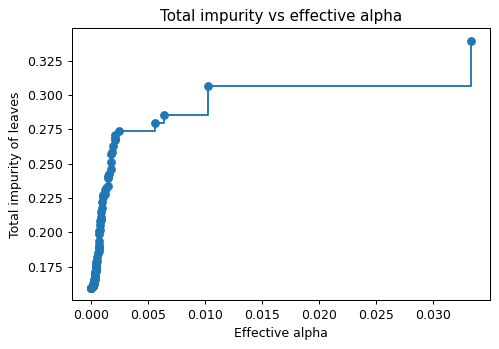

In [9]:
path = dt.cost_complexity_pruning_path(titanic_features_train, titanic_labels_train)

ccp_alphas, impurities = path.ccp_alphas, path.impurities

fig, ax = plt.subplots(dpi=90)
ax.plot(ccp_alphas[:-1], impurities[:-1], marker='o', drawstyle="steps-post")
ax.set_xlabel("Effective alpha")
ax.set_ylabel("Total impurity of leaves")
ax.set_title("Total impurity vs effective alpha")

plt.show()

In [10]:
best_pruning = []
for ccp_alpha in ccp_alphas:
    if ccp_alpha >= 0:
        dt = DecisionTreeClassifier(random_state=0, ccp_alpha=ccp_alpha)
        dt.fit(titanic_features_train, titanic_labels_train)
        best_pruning.append([ccp_alpha, dt.score(titanic_features_test, titanic_labels_test)])
best_pruning = sorted(best_pruning, key=lambda x: x[1], reverse=True)

best_ccp_alpha = best_pruning[0][0]

dt = DecisionTreeClassifier(random_state=0, ccp_alpha=best_ccp_alpha)
dt.fit(titanic_features_train.values, titanic_labels_train)

accuracy = dt.score(titanic_features_test.values, titanic_labels_test)

print("Test accuracy: {:.3f}".format(accuracy))
print("Number of nodes in the last tree is: {} with ccp_alpha: {:.3f}".format(dt.tree_.node_count, best_ccp_alpha))

Test accuracy: 0.805
Number of nodes in the last tree is: 13 with ccp_alpha: 0.003


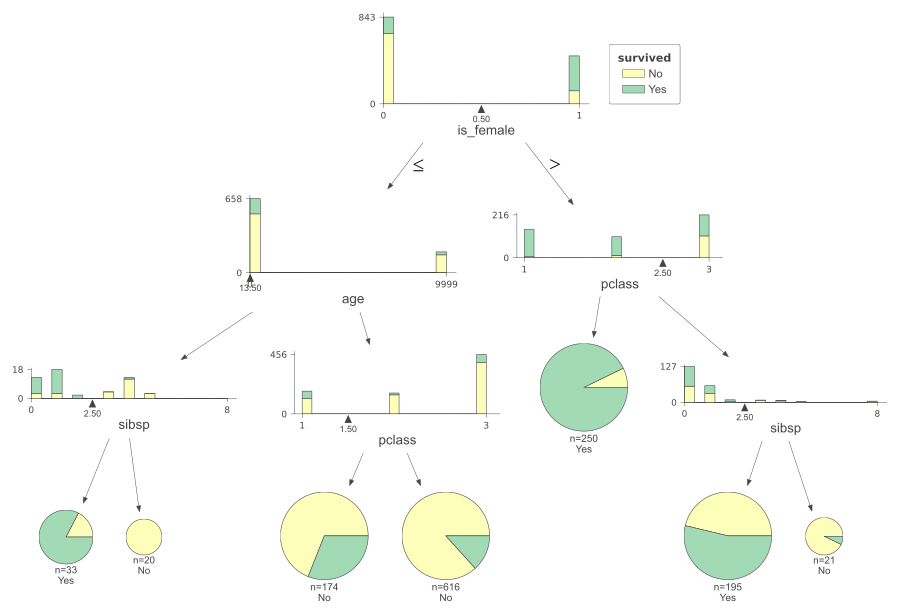

In [11]:
dtreeviz(dt, titanic_features, titanic_labels, target_name='survived', feature_names=titanic_features.columns, class_names=['No', 'Yes'], scale=1.5)

## Naive Bayes

### Tennis

In [12]:
prob_outcomes = tennis.play.value_counts(sort=False, normalize=True)
outlook = pd.crosstab(tennis.outlook, tennis.play, normalize='columns')
temperature = pd.crosstab(tennis.temperature, tennis.play, normalize='columns')
humidity = pd.crosstab(tennis.humidity, tennis.play, normalize='columns')
wind = pd.crosstab(tennis.wind, tennis.play, normalize='columns')

In [13]:
proba = prob_outcomes*outlook.loc['Sunny']*temperature.loc['Mild']*wind.loc['Weak']*humidity.loc['Normal']
proba

0    0.006857
1    0.028219
dtype: float64

### Spam classification

In [14]:
spam = pd.read_feather("../datasets/spam.feather")
spam_features = spam.iloc[:,:-1]
spam_labels = spam.iloc[:,-1]

In [15]:
nb = BernoulliNB()
preds = cross_val_predict(nb, spam_features, spam_labels, cv=5, n_jobs=-1)

In [16]:
print(classification_report(y_true=spam_labels, y_pred=preds, target_names=['Not spam', 'Spam']))

              precision    recall  f1-score   support

    Not spam       0.89      0.92      0.90      2788
        Spam       0.87      0.82      0.84      1813

    accuracy                           0.88      4601
   macro avg       0.88      0.87      0.87      4601
weighted avg       0.88      0.88      0.88      4601

